# Linear Neural Network - Logistic Regression (Linearly Separable Data)

In this notebook, we cast the Logistic Regression model for Binary classification as a Linear Neural Network (LNN) model.

Using the LNN model, we perform binary classification on a **linearly separable** dataset. Then, we visualize the decision boundary.

For creating the LNN, we use the **Keras API with TensorFlow 2.0 as the backend**.


## Create Artificial Neural Networks (ANNs) using Keras

Keras is a high-level Deep Learning API that allows to easily build, train, evaluate, and execute all sorts of ANNs. TensorFlow 2 has adopted Keras as its official high-level API: **tf.keras**. 

We will use Keras to build the LNN. It involves two steps.
- Choose a suitable Keras model class & create the model using it
- Add layers of different types based on the need

### Step 1: Instantiate a Model using the Sequential API
The Sequential API is a straightforward and simple list of layers. It is limited to single-input, single-output stacks of layers.
https://keras.io/api/models/


### Step 2: Add Suitable Layers

Layers are the basic building blocks of neural networks in Keras: https://keras.io/api/layers/ 

For building a LNN, we only need to add **Dense layers**, which is a core layer is Keras: https://keras.io/api/layers/core_layers/dense/

Dense layer implements the following operation: 

    output = activation(dot(input, kernel) + bias) 

where activation is the element-wise activation function passed as the activation argument, kernel is a weight matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

The tf.keras.layers.Dense class has the following parameters:

- units: Number of output neurons.

- activation (default: **"linear" activation**): Activation function to use.

- use_bias (default: **True**): Boolean, whether the layer uses a bias vector.

- kernel_initializer (default: **"glorot_uniform"**): Initializer for the kernel weights matrix.

- bias_initializer (default: **"zeros"**): Initializer for the bias vector.

- kernel_regularizer (default: None): Regularizer function applied to the kernel weights matrix.

- bias_regularizer (default: None): Regularizer function applied to the bias vector.

- activity_regularizer (default: None): Regularizer function applied to the output of the layer (its "activation").

- kernel_constraint (default: None): Constraint function applied to the kernel weights matrix.

- bias_constraint (default: None): Constraint function applied to the bias vector.


Note that by deault Glorot Uniform weight initialization technique is used. Generally the **He initialization** works well with the ReLU activation function (kernel_initializer="he_normal") in deep ANNs. 


### Note: Constructing the LNN Model

For constructing the LNN model, we will:
- Initialize the network weights with zero values
- Use the sigmoid activation function for binary classification and the softmax activation function for multi-class classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf

np.random.seed(43)

## Decision Bounday: Using Various Thresholds for a Class Probability

We define a function to show the decision boundaries at various thresholds of a class probability. Using the different estimates for a single class, we generate a contour plot. 

In [2]:
def decision_boundary_class_colored(clf, X):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points    
    y_pred_proba = clf.predict(X_new).reshape(x1.shape)

    y_pred = y_pred_proba
            
    for i in range(y_pred_proba.shape[0]):
        for j in range(y_pred_proba.shape[1]):
            if(y_pred_proba[i][j] >= 0.5):
                y_pred[i][j] = 1
            else:
                y_pred[i][j] = 0
        
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.summer, alpha=0.9)

## Synthetic Dataset: Linearly Separable


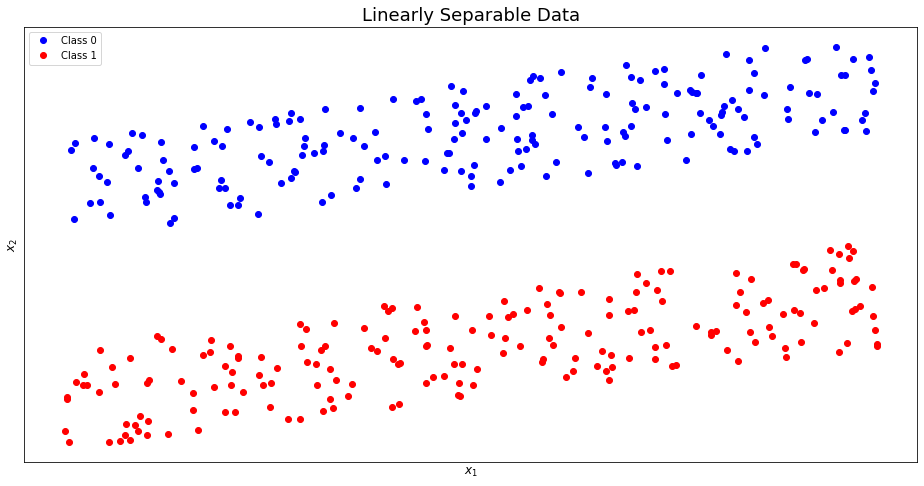

In [3]:
m0 = 200  # no. of training examples for class 0

# Generate class 0 data points randomly from a uniform distribution
#    Here a & b are 2 dimensions for each data (feature) point
a = np.random.rand(m0,1)
b = 4 + a + np.random.rand(m0,1)

# Concatenate the 2 dimensions of each feature to create the data matrix for class 0 
X0 = np.concatenate((a, b), axis=1)

# Create the target vector for class 0 (target is coded with zeros)
X0_target = np.zeros((m0,), dtype=np.int).reshape(-1, 1)

m1 = 200  # no. of training examples for class 1

# Generate class 1 data points randomly from a uniform distribution
#    Here c & d are 2 dimensions for each data (feature) point
c = np.random.rand(m1,1)
d = 6 + c + np.random.rand(m1,1)

# Concatenate the 2 dimensions of each feature to create the data matrix for class 1
X1 = np.concatenate((c, d), axis=1)

# Create the target vector for class 1 (target is coded with ones)
X1_target = np.ones((m1,), dtype=np.int).reshape(-1, 1)

# All training examples for class 0 and 1
X = np.append(X0, X1, axis=0)

# All target values for class 0 & 1
y = np.concatenate((X0_target, X1_target), axis=0)

# Create a 1D row vector ofthe target with float values
y = y.ravel()*1.0

# Draw a scatter plot
plt.figure(figsize=(16,8))
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")
plt.title("Linearly Separable Data", fontsize=18)
plt.legend(loc=2)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", rotation=90, fontsize=12)
plt.xticks(())
plt.yticks(())
plt.show()

## Create a LNN Model

Using the Keras Dense layer we create a LNN model for Logistic Regression. **In a Dense layer, each neuron is connected to all input/neurons of the previous layer**.

The LNN model:
- has only one neuron.
- uses the logistic sigmoid function.

At first, we need to specify the shape of the input using the Input layer. The Input layer is used to instantiate a Keras tensor, which is a TensorFlow symbolic tensor object.
- We must set the "shape" parameter, which is a tuple (integers) idicating the dimension of the input vectors. In this demo, input is a 2D vector, that's why we simply put [2, ] in the tuple. In image classification problems, an image input will be represented as a matrix, in which case we will need to specify the size of the matrix. For example, for 28 x 28 image input matrix, "shape" tuple will be [28, 28]. Note that we don't need to include the batch size.

In the Dense layer, we explicitly show the "use_bias" parameter. By default, it's set to "True". If we change it to "False", the model doesn't learn the bias (i.e., "height" in this 2D example). The goal of explicitly showing the "use_bias" parameter is to emphasize its impact on model learning.
- kernel_initializer: we initialize the weights (also known as kernel) with zero values. In logistic/softmax regression, initial zero weight values are ok. However, in nonlinear neural networks, such as in Multi-layer Perceptrons (MLPs), we must use small random values to initialize the weights. For that we need to use sophisticated initializers, such as glorot or he.
- activation: we use logistic sigmoid


In [7]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)

'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = tf.keras.models.Sequential(name="LNN_Binary_Classifier")
model.add(tf.keras.layers.InputLayer(input_shape=[2, ]))
model.add(tf.keras.layers.Dense(units=1, kernel_initializer="zeros", activation="sigmoid", use_bias=True))

'''
Display a summary of the model layers and its parameters
'''
model.summary()

Model: "LNN_Binary_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
CPU times: user 12.5 ms, sys: 2.25 ms, total: 14.8 ms
Wall time: 12.6 ms


## Compile & Train the LNN Model


A Keras model automatically uses the **Backpropagation** algorithm to train an ANN. However, we need to specify an optimization algorithm. 

There are various advanced optimizers. For the LNN, we will use the **Stochastic Gradient Descent (SGD)** optimizer. It requires us to set a suitable learning rate.  

We will use the mini-batch SGD. Thus, we need to specify the batch size as well as the epochs.

In [10]:
'''
Define the optimizer
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.9)

'''
Compile the model
'''
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Set the epochs and batch size
'''
no_of_epochs = 50
size_of_mini_batch = 64


'''
Train the model
'''
history = model.fit(X, y, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    validation_split=0.1, # Fraction of the training data to be used as validation data. 
                    verbose=1)

Epoch 1/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0484 - accuracy: 1.0000 - val_loss: 0.0502 - val_accuracy: 1.0000
Epoch 2/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0463 - accuracy: 1.0000 - val_loss: 0.0504 - val_accuracy: 1.0000
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0453 - accuracy: 1.0000 - val_loss: 0.0401 - val_accuracy: 1.0000
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0448 - accuracy: 1.0000 - val_loss: 0.0578 - val_accuracy: 1.0000
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0460 - accuracy: 1.0000 - val_loss: 0.0349 - val_accuracy: 1.0000
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0446 - accuracy: 1.0000 - val_loss: 0.0558 - val_accuracy: 1.0000
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0448 - accuracy: 1.0000 - val_loss: 0.0475 - val_accuracy: 1.0000
Epoch 8/50
6/6 [=================

## Evaluate the LNN Model

In [6]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X, y, verbose=0))


y_predicted_proba = model.predict(X)

print(len(y_predicted_proba))

y_predicted = y_predicted_proba

for i in range(len(y_predicted)):
    if(y_predicted_proba[i] >= 0.5):
        y_predicted[i] = 1
    else:
        y_predicted[i] = 0


y_predicted = y_predicted.ravel()
accuracy = np.mean(y_predicted == y)
print("\nAccuracy: ", accuracy)



print("\nConfusion Matrix:")
print(confusion_matrix(y, y_predicted))

print("\nClassification Report:")
print(classification_report(y, y_predicted))

Epochs:  50

Test Data: Loss & Accuracy:  [0.05491166189312935, 1.0]
400

Accuracy:  1.0

Confusion Matrix:
[[200   0]
 [  0 200]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       200
         1.0       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



## Plot The Decision Boundary

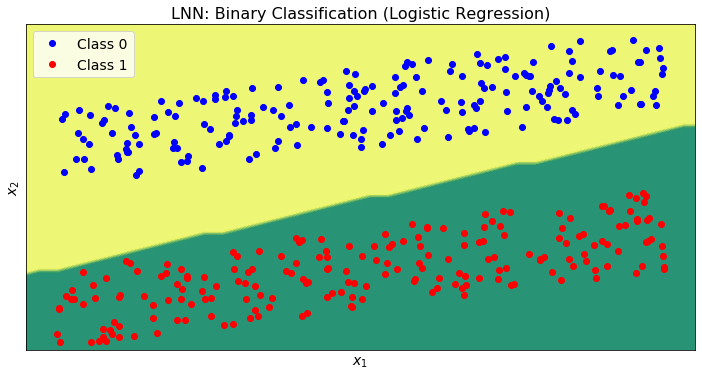

In [7]:
plt.figure(figsize=(12, 6))    

decision_boundary_class_colored(model, X)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("LNN: Binary Classification (Logistic Regression)", fontsize=16)
plt.xticks(())
plt.yticks(())
plt.axis([-0.05, 1.05, 4, 8.05])

plt.show()